In [295]:
# !pip install -q git+https://github.com/huggingface/transformers.git

^C
ERROR: Operation cancelled by user

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [334]:
!pip install -q timm

from transformers import DetrFeatureExtractor
import torch
import fitz  # PyMuPDF
from PIL import Image
from transformers import TableTransformerForObjectDetection
import matplotlib.pyplot as plt



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [335]:

def get_image(file_path: str):
# Open the PDF file
    pdf_document = fitz.open(file_path)

    # Iterate through each page
        # Get the page
    page = pdf_document.load_page(11)
    pix = page.get_pixmap()
    image_path = f"page_{page_number}.png"
    pix.save(image_path)

    # Now you can open and process it with PIL
    image = Image.open(image_path).convert("RGB")
    width, height = image.size
    image.resize((int(width*0.5), int(height*0.5)))
    return image

image = get_image("/Users/danielbasman/Desktop/Desktop - Daniel’s MacBook Pro/MyStuff/Classes/Human In Loop/10-K.pdf")


In [336]:

feature_extractor = DetrFeatureExtractor()
encoding = feature_extractor(image, return_tensors="pt")
encoding.keys()
print(encoding['pixel_values'].shape)

model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-detection")

with torch.no_grad():
  outputs = model(**encoding)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/models/detr/feature_extraction_detr.py:38: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(


torch.Size([1, 3, 1035, 800])


Some weights of the model checkpoint at microsoft/table-transformer-detection were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Let's visualize the results!

In [337]:

def plot_box(pil_img, boxes):
    COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    
    ax.add_patch(plt.Rectangle((boxes[1], boxes[2]), boxes[3] - boxes[1], -(boxes[2] - boxes[0]),
                                   fill=False, color='red', linewidth=3))
    
    print("height: ", boxes[2] - boxes[0])
    print("width: ", boxes[3] - boxes[1])
    plt.axis('on')

    plt.show()
    
def plot_results(pil_img, scores, labels, boxes):
    COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=8,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('on')

    plt.show()

In [340]:

width, height = image.size
print(width, height)
results = feature_extractor.post_process_object_detection(outputs, threshold=0.001, target_sizes=[(height, width)])[0]

left = []
right = []
top = []
bottom = []

for i in results["boxes"]:
    top.append(i[3])
    right.append(i[2])
    left.append(i[0])
    bottom.append(i[1])
    # print("top y: ", i[3], "bottom y: ", i[1], "right x: ", i[2], "left x: ", i[0])
    
# print(left)
final = []

for i in [bottom, left]:
    # print(i)
    min_value = min(tensor.min() for tensor in i)
    # print(min_value)
    final.append(min_value)

for i in [top, right]:
    # print(i)
    max_value = max(tensor.max() for tensor in i)
    # print(max_value)
    final.append(max_value)
# print(final)
print("Anchor")
print(final[1])
print(final[2])


612 792
Anchor
tensor(95.5135)
tensor(473.9598)


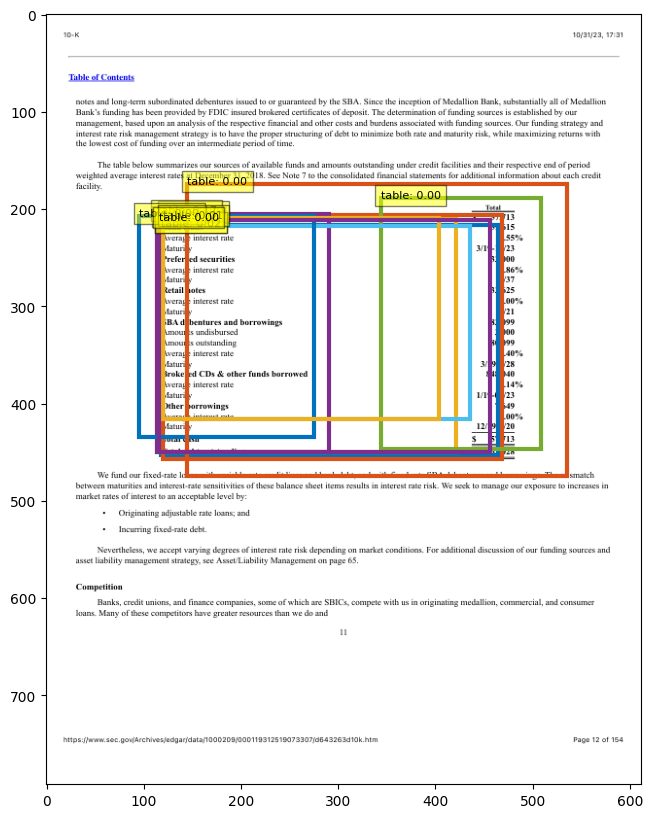

height:  tensor(299.8047)
width:  tensor(439.3665)


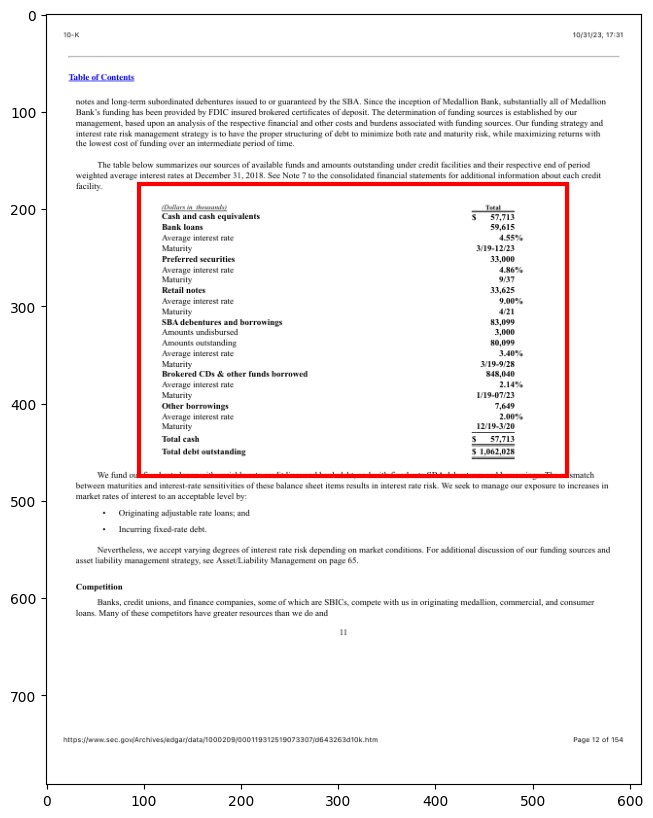

In [341]:
plot_results(image, results['scores'], results['labels'], results['boxes'])
plot_box(image, final)
# plot_results(image, final)

In [342]:

width, height = image.size
image.resize((int(width*0.5), int(height*0.5)))

x =  int(final[1])
y = int(final[0])
width = int(final[3] - final[1])
height = int(final[2] - final[0])
print(x, y, width, height)
cropped_image = image.crop((x, y, x + width, y + height))
cropped_image.save('cropped_portion.png')

cropped_image.show()

95 174 439 299


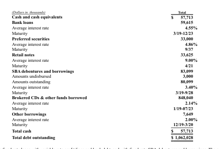

In [343]:
from huggingface_hub import hf_hub_download
from PIL import Image

# file_path = hf_hub_download(repo_id="nielsr/example-pdf", repo_type="dataset", filename="example_table.png")
# page = pdf_document.load_page(4)
# pix = page.get_pixmap()
# image_path = f"page_{page_number}.png"
# pix.save(image_path)

# Now you can open and process it with PIL
# image = Image.open(image_path).convert("RGB")
# /Users/danielbasman/Desktop/Screenshot 2023-11-16 at 15.08.17.png
image = Image.open("./cropped_portion.png").convert("RGB")

# image = Image.open("/Users/danielbasman/Downloads/table.png").convert("RGB")

# image = Image.open(file_path).convert("RGB")
width, height = image.size
image.resize((int(width*0.5), int(height*0.5)))

In [344]:
encoding = feature_extractor(image, return_tensors="pt")
encoding.keys()

dict_keys(['pixel_values', 'pixel_mask'])

In [345]:
from transformers import TableTransformerForObjectDetection

model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-structure-recognition")

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [346]:
with torch.no_grad():
  outputs = model(**encoding)

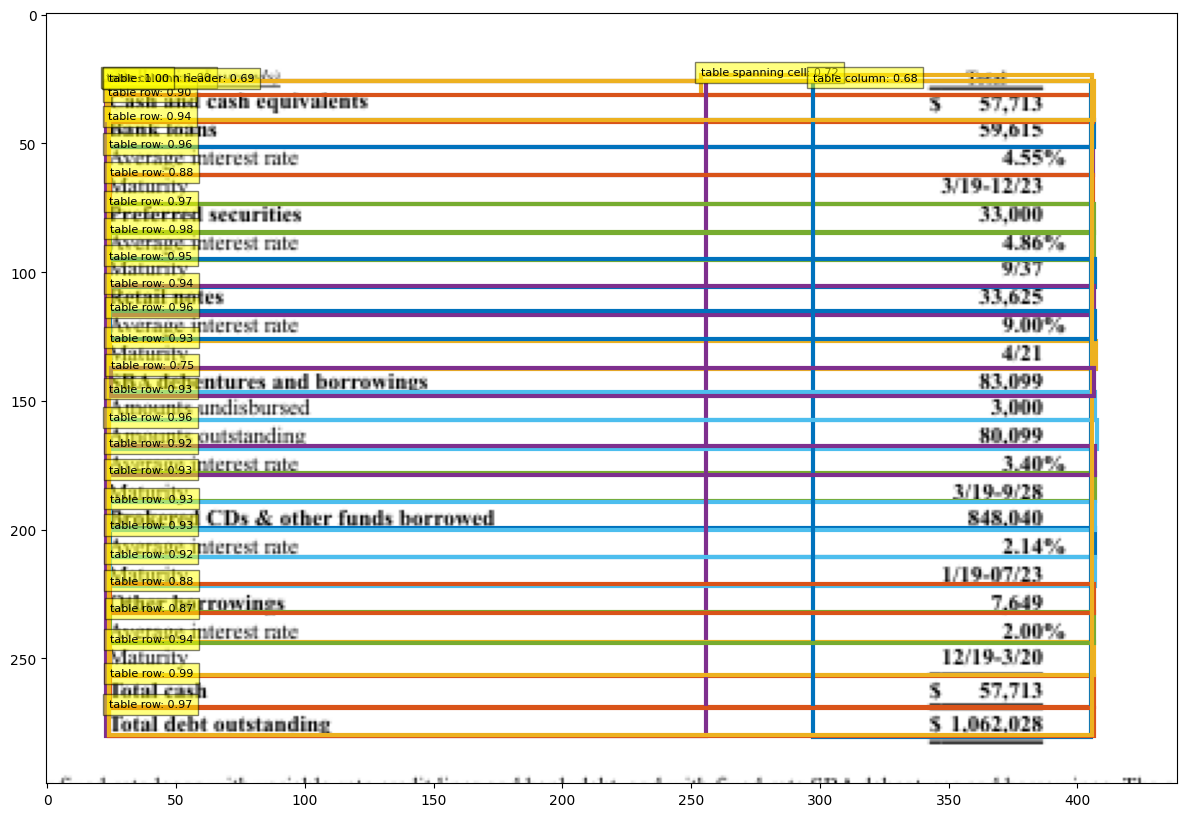

In [347]:
target_sizes = [image.size[::-1]]
results = feature_extractor.post_process_object_detection(outputs, threshold=0.6, target_sizes=target_sizes)[0]
plot_results(image, results['scores'], results['labels'], results['boxes'])

In [318]:
model.config.id2label

{0: 'table',
 1: 'table column',
 2: 'table row',
 3: 'table column header',
 4: 'table projected row header',
 5: 'table spanning cell'}